# 音データの前処理・次元削減　Hz領域からmel領域へ

## 内容

* メル尺度とは
* 実際にメル変換してみる
* おまけ：メル逆変換してみる


## 導入
音声データ分析する時，1chだと特にスペクトログラムで分析する事が多いよね．
そんで音声データもサンプリングレートが10000Hzを上回ることもざらですよね．
なので次元を落としたい！
ってことでHzからメル尺度へ変換です．

## メル尺度ってなんぞや
音声データ（音響データ含む）に行う前処理・次元削減として使われる
人間の感覚に近い音の尺度ってことでわりと好まれてる
周波数が2倍になるとオクターブが1上がり，周波数が4倍になるとオクターブが2上がるといった音の高さに着目した尺度みたい．

$$m = m_0 \ln\Bigl(\frac{f}{f_0}+1\Bigr)$$
なので周波数$f$に対して対数(log)をとってますね．

定義では1000メルが1000Hzになるようにしているらしいけど，定義をそのまま使うことはほぼない...
よく使われるのは，音声データをメル尺度上で等分割するって手法で，
例1：1次元目には$0\sim10$メル尺度, 2次元目には$5\sim15$メル尺度の区間の情報が入るようにする．
例2：1次元目には$0\sim3.0$メル尺度, 2次元目には$1.5\sim4.5$メル尺度の区間の情報が入るようにする．
pythonの音響ライブラリのlibrosaなんかもこれでやってる

具体的に見ていくと,周波数空間に対して以下のような三角窓(窓関数)をかけていきます.
この三角窓たちをmel filter bank（メルフィルタバンク）と言ったりします．
Hzスペクトログラム:$F$ ，メルフィルタバンク:$W $  ，melスペクトログラム:$M$
$$M = WF$$

### メルフィルタバンクと三角窓の例
sampling-rate:10000Hz
mel-channel(メル空間上での分割する数): 10

以下のように三角窓の面積が1になるようにかけるのが一般的（librosaではこれがデフォルト）
引数としてnorm="slaney"を与えるけど，このslaneyが何者かわからんw

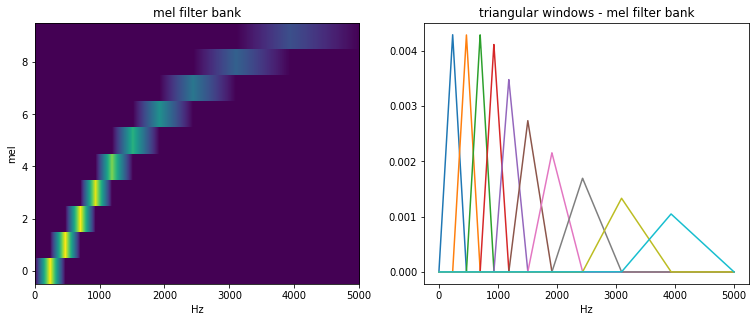

In [217]:
ssr=10000
m=10
melfb = librosa.filters.mel(sr=ssr, n_fft=ssr, n_mels=m, norm="slaney")
plt.figure(figsize=(2*6.4, 4.8))
ax=plt.subplot(1,2,1)
ax.imshow(melfb, aspect="auto", origin="lower")
ax.set_xlabel("Hz")
ax.set_ylabel("mel")
ax.set_title("mel filter bank")
ax=plt.subplot(1,2,2)
ax.plot(melfb.T)
ax.set_xlabel("Hz")
ax.set_title("triangular windows - mel filter bank")
plt.show()

1000Hzが1000メルという定義のため，1000Hzまでの区間はほぼ三角窓の高さが一定(単位メル領域にあたるHzの区間が等しい)になっている

以下のように三角窓の高さが1になるようにする場合もある

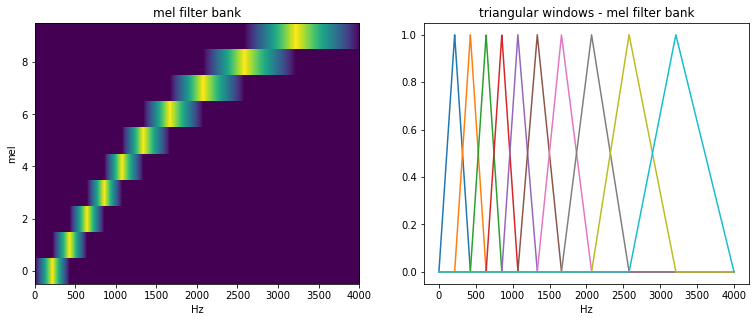

In [193]:
melfb = librosa.filters.mel(sr=ssr, n_fft=ssr, n_mels=m, norm=None)
plt.figure(figsize=(2*6.4, 4.8))
ax=plt.subplot(1,2,1)
ax.imshow(melfb, aspect="auto", origin="lower")
ax.set_xlabel("Hz")
ax.set_ylabel("mel")
ax.set_title("mel filter bank")
ax=plt.subplot(1,2,2)
ax.plot(melfb.T)
ax.set_xlabel("Hz")
ax.set_title("triangular windows - mel filter bank")
plt.show()

## 実際に適用して，Hzスペクトログラムとmelスペクトログラムを比べてみる

In [192]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
melc=64

librosaからサンプル音源(trumpet)を持ってきて適用する　　

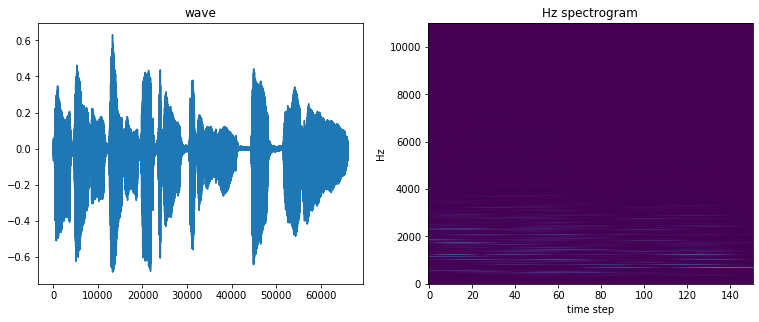

sampling rate: 22050


In [412]:
filename = librosa.example("trumpet")
data, sr = librosa.load(filename, mono=True)
data = data[:3*sr]
plt.figure(figsize=(2*6.4, 4.8))
ax=plt.subplot(1,2,1)
ax.plot(data)
ax.set_title("wave")

hz_spec= librosa.stft(data, n_fft=sr, hop_length=sr//50)
ax=plt.subplot(1,2,2)
ax.imshow(np.abs(hz_spec), aspect="auto", origin="lower")
ax.set_xlabel("time step")
ax.set_ylabel("Hz")
ax.set_title("Hz spectrogram")
plt.show()
# コメントアウトした文を別のcellで実行することでNotebook上で音が聴けます
# import IPython.display
# IPython.display.Audio(data, rate=sr) 
print("sampling rate: " +  str(sr))

### 面積1のメルフィルタバンクでメル変換

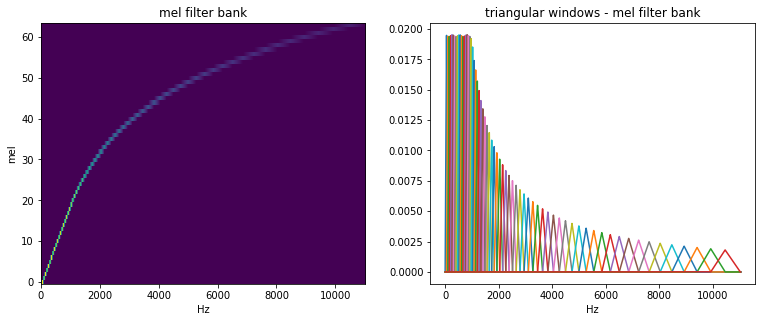

In [254]:
melfb = librosa.filters.mel(sr=sr, n_fft=sr, n_mels=melc, norm="slaney")
plt.figure(figsize=(2*6.4, 4.8))
ax=plt.subplot(1,2,1)
ax.imshow(melfb, aspect="auto", origin="lower")
ax.set_xlabel("Hz")
ax.set_ylabel("mel")
ax.set_title("mel filter bank")
ax=plt.subplot(1,2,2)
ax.plot(melfb.T)
ax.set_xlabel("Hz")
ax.set_title("triangular windows - mel filter bank")
plt.show()

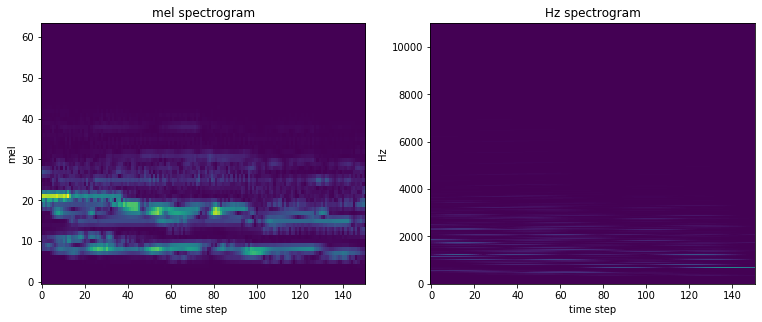

In [196]:
mel_spec=np.dot(melfb, hz_spec)
plt.figure(figsize=(2*6.4, 4.8))
ax=plt.subplot(1,2,1)
ax.imshow(np.abs(mel_spec), aspect="auto", origin="lower")
ax.set_xlabel("time step")
ax.set_ylabel("mel")
ax.set_title("mel spectrogram")
ax=plt.subplot(1,2,2)
ax.imshow(np.abs(hz_spec), aspect="auto", origin="lower")
ax.set_xlabel("time step")
ax.set_ylabel("Hz")
ax.set_title("Hz spectrogram")
plt.show()

### 高さ1のメルフィルタバンクでメル変換

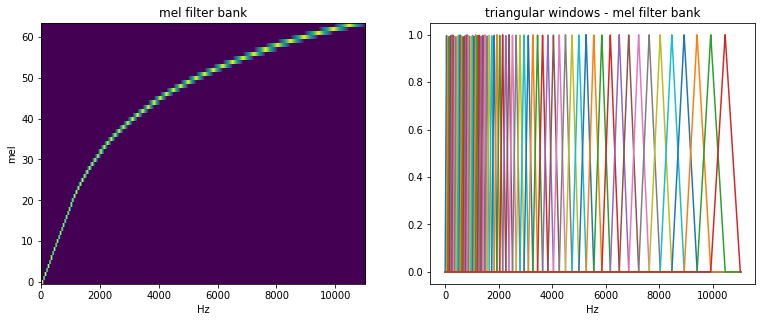

In [197]:
melfb = librosa.filters.mel(sr=sr, n_fft=sr, n_mels=melc, norm=None)
plt.figure(figsize=(2*6.4, 4.8))
ax=plt.subplot(1,2,1)
ax.imshow(melfb, aspect="auto", origin="lower")
ax.set_xlabel("Hz")
ax.set_ylabel("mel")
ax.set_title("mel filter bank")
ax=plt.subplot(1,2,2)
ax.plot(melfb.T)
ax.set_xlabel("Hz")
ax.set_title("triangular windows - mel filter bank")
plt.show()

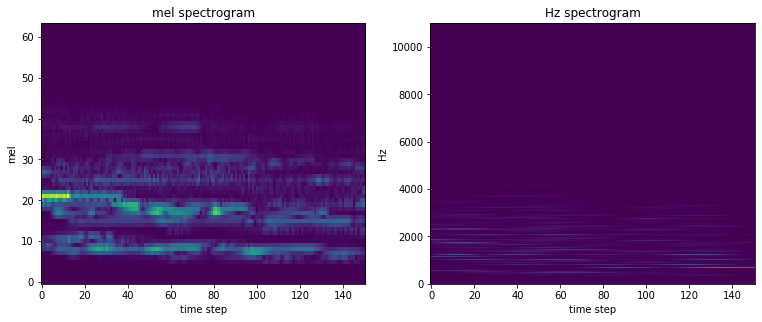

In [198]:
mel_spec=np.dot(melfb, hz_spec)
plt.figure(figsize=(2*6.4, 4.8))
ax=plt.subplot(1,2,1)
ax.imshow(np.abs(mel_spec), aspect="auto", origin="lower")
ax.set_xlabel("time step")
ax.set_ylabel("mel")
ax.set_title("mel spectrogram")
ax=plt.subplot(1,2,2)
ax.imshow(np.abs(hz_spec), aspect="auto", origin="lower")
ax.set_xlabel("time step")
ax.set_ylabel("Hz")
ax.set_title("Hz spectrogram")
plt.show()

## おまけ：mel領域からHz領域へのメル逆変換
$$F'=\bar{W}M$$
完全な逆変換は不可能だけど，三角窓を使って値を分配することでそれっぽいものを作ります  
$$F' = \alpha F$$
のようにもとのHzスペクトログラムの相対的な大小関係は維持でき，スペクトログラム画像表示だと同じようになるはず  

In [450]:
def melspec2hzspec(mel_spec, sr, melc, norm):
    unit_mel = librosa.hz_to_mel(sr//2) / (melc+1)
    mel_range = np.arange(melc+2)*unit_mel
    hz_range = librosa.mel_to_hz(mel_range)
    hz_range = np.rint(hz_range).astype(int)
#     print(hz_range)

    left_reverse_melfb = []
    right_reverse_melfb = []
    reverse_melfb = []
    for bc, cc, ac in zip(hz_range[:-2], hz_range[1:-1], hz_range[2:]):
#         print(bc, cc, ac)
        if norm == "slaney":
            h = 2 / (ac - bc) 
        elif norm is None:
            h = 1
        left_deriv = h / (cc - bc)
        right_deriv =- h /(ac - cc)
        left_reverse_window = [left_deriv*(i - bc) if (i > bc and i <= cc)  else 0 for i in range(sr//2 +1)]
        right_reverse_window = [right_deriv*(i - ac) if (i > cc and i <= ac) else 0 for i in range(sr//2 +1)]
        left_reverse_melfb.append(left_reverse_window)
        right_reverse_melfb.append(right_reverse_window)
    left_reverse_melfb = np.array(left_reverse_melfb)
    right_reverse_melfb = np.array(right_reverse_melfb)
    reverse_melfb = left_reverse_melfb + right_reverse_melfb
    reverse_melfb = reverse_melfb.T
    return reverse_melfb, np.dot(reverse_melfb, mel_spec)

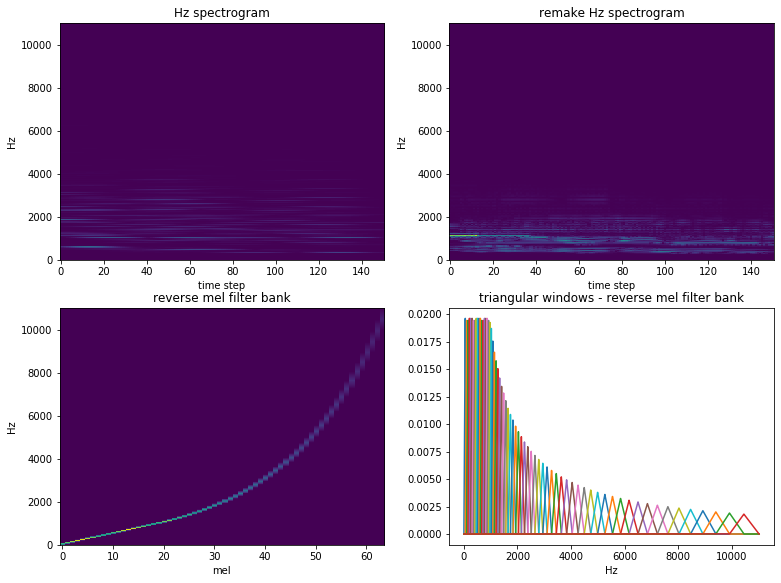

In [449]:
norm= "slaney"
reverse_melfb, re_hz_spec = melspec2hzspec(mel_spec, sr=sr, melc=melc, norm=norm)
melfb = librosa.filters.mel(sr=sr, n_fft=sr, n_mels=melc, norm=norm)
plt.figure(figsize=(2*6.4, 2*4.8))
ax=plt.subplot(2,2,1)
ax.imshow(np.abs(hz_spec), aspect="auto", origin="lower")
ax.set_xlabel("time step")
ax.set_ylabel("Hz")
ax.set_title("Hz spectrogram")

ax=plt.subplot(2,2,2)
ax.imshow(np.abs(re_hz_spec), aspect="auto", origin="lower")
ax.set_xlabel("time step")
ax.set_ylabel("Hz")
ax.set_title("remake Hz spectrogram")

ax=plt.subplot(2,2,3)
ax.imshow(reverse_melfb, aspect="auto", origin="lower")
ax.set_xlabel("mel")
ax.set_ylabel("Hz")
ax.set_title("reverse mel filter bank")

ax=plt.subplot(2,2,4)
ax.plot(reverse_melfb)
ax.set_xlabel("Hz")
ax.set_title("triangular windows - reverse mel filter bank")
plt.show()

Hzスペクトログラムがちょっと違っているように見えるので再度メル変換して比較してみる

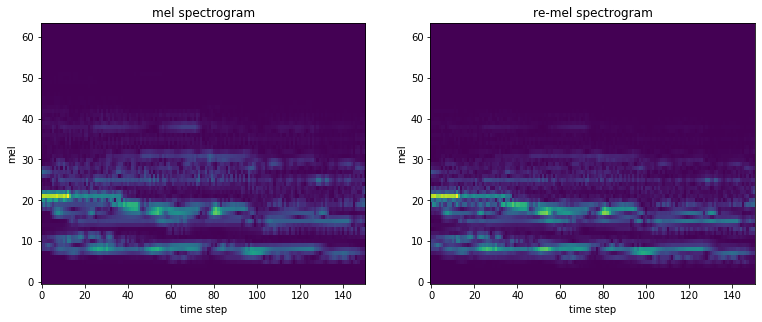

In [454]:
re_mel_spec=np.dot(melfb, re_hz_spec)
plt.figure(figsize=(2*6.4, 4.8))
ax=plt.subplot(1,2,1)
ax.imshow(np.abs(mel_spec), aspect="auto", origin="lower")
ax.set_xlabel("time step")
ax.set_ylabel("mel")
ax.set_title("mel spectrogram")
ax=plt.subplot(1,2,2)
ax.imshow(np.abs(re_mel_spec), aspect="auto", origin="lower")
ax.set_xlabel("time step")
ax.set_ylabel("mel")
ax.set_title("re-mel spectrogram")
plt.show()

元のメルスペクトログラムも再変換したメルスペクトログラムも見た目は変わらなかった
やはり逆変換そのものが，かなり無茶だったみたい  (64次元を11000次元にしてるからまぁ当然)

#### おまけのおまけ
作ってから気づいたけど，`reverse_melfb`って`melfb.T`と一緒だったw  
だからこれでよかった

In [448]:
def melspec2hzspec_simple(mel_spec, sr, melc, norm):
    reverse_melfb = librosa.filters.mel(sr=sr, n_fft=sr, n_mels=melc, norm=norm).T
    return reverse_melfb, np.dot(reverse_melfb, mel_spec)